In [159]:
import pandas as pd 
import numpy as np 
import emcee 
import corner 
import matplotlib.pyplot as plt
from scipy.stats import norm
from tqdm import tqdm



In [160]:
df = pd.read_csv('test_emcee.csv', names=['id', 'x', 'xerrl', 'xerru', 'y', 'yerrl', 'yerru'], header=0)
df = df = df[~df['x'].isna() & (df['x'] != -np.inf)]

In [161]:
df

,id,x,xerrl,xerru,y,yerrl,yerru
0,1,-1.284693,0.176102,0.216866,1.644104,0.193874,0.231135
2,3,-0.810841,0.202710,0.194648,1.707728,0.192076,0.213778
4,5,-0.321727,0.178127,0.184521,1.717245,0.099932,0.110270
5,6,-0.690510,0.281219,0.180548,1.786965,0.147592,0.672152
6,7,-0.170246,0.185447,0.223091,1.952145,0.255089,0.364265
7,8,-0.444281,0.176657,0.191723,1.708126,0.123847,0.139456
8,9,-1.458283,0.179785,0.179486,1.604787,0.102782,0.111156
9,10,-0.259773,0.176361,0.179733,1.719006,0.068193,0.082332
11,12,-0.893923,0.182282,0.206601,1.880820,0.203829,0.305401
12,13,-0.256131,0.201143,0.177858,1.864040,0.128695,0.152877


In [166]:
def bayesian_regression_mcmc(x, y, x_err_lower, x_err_upper, y_err_lower, y_err_upper, num_realizations=100, n_walkers=10, n_steps=1000, x_min=None, x_max=None):
    """
    Performs Bayesian linear regression using emcee with asymmetric error bars.
    
    Parameters:
    x (array-like): Independent variable.
    y (array-like): Dependent variable.
    y_err_lower (array-like): Lower uncertainties on y (90% confidence level).
    y_err_upper (array-like): Upper uncertainties on y (90% confidence level).
    num_realizations (int): Number of Monte Carlo realizations.
    n_walkers (int): Number of MCMC walkers.
    n_steps (int): Number of MCMC steps.
    
    Returns:
    dict: Dictionary with slope, intercept, and confidence intervals for regression.
    """

    # Define log-likelihood function
    def log_likelihood(theta, x, y):
        """Gaussian likelihood for linear regression"""
        intercept, slope = theta
        model = intercept + slope * x
        sigma = np.std(y)  # Approximate scatter
        return -0.5 * np.sum(((y - model) / sigma) ** 2 + np.log(2 * np.pi * sigma ** 2))

    # Define log-prior function
    def log_prior(theta):
        """Uniform priors on intercept and slope"""
        intercept, slope = theta
        if -10 < intercept < 10 and -10 < slope < 10:
            return 0.0  # Flat prior
        return -np.inf  # Outside allowed range

    # Define full log-posterior function
    def log_probability(theta, x, y):
        """Combined log-posterior = log-prior + log-likelihood"""
        lp = log_prior(theta)
        if not np.isfinite(lp):
            return -np.inf
        return lp + log_likelihood(theta, x, y)

    # Define function for Half-Gaussian sampling
    def sample_half_gaussian(y_best, y_err_low, y_err_high):
        """Samples y from an asymmetric Half-Gaussian distribution."""
        if np.random.rand() < 0.5:
            return y_best - abs(norm.rvs(scale=y_err_low))
        else:
            return y_best + abs(norm.rvs(scale=y_err_high))

    # Generate best-fit x range for plotting
    x_plot_min = x_min if x_min is not None else min(x)
    x_plot_max = x_max if x_max is not None else max(x)
    x_plot = np.linspace(x_plot_min, x_plot_max, 100)

    # Initialize arrays to store confidence intervals
    y_median = np.zeros_like(x_plot)
    y_lower = np.zeros_like(x_plot)
    y_upper = np.zeros_like(x_plot)

    # Store slope and intercept results
    slopes = []
    intercepts = []
    all_samples = []

    # Run Monte Carlo sampling
    for _ in tqdm(range(num_realizations), desc="Running MCMC realizations"):
        # Sample x and y values from asymmetric Half-Gaussian distribution
        x_sampled = np.array([
            sample_half_gaussian(x[i], x_err_lower[i], x_err_upper[i])
            for i in range(len(x))
        ])
        y_sampled = np.array([
            sample_half_gaussian(y[i], y_err_lower[i], y_err_upper[i])
            for i in range(len(y))
        ])
        
        # Initialize MCMC
        pos = np.random.randn(n_walkers, 2)  # Random initial positions

        # Run MCMC using emcee
        sampler = emcee.EnsembleSampler(n_walkers, 2, log_probability, args=(x_sampled, y_sampled))
        sampler.run_mcmc(pos, n_steps, progress=False)

        # Extract samples
        samples = sampler.get_chain(discard=100, thin=10, flat=True)
        all_samples.append(samples)

        # Store median slope and intercept from this iteration
        slopes.append(np.median(samples[:, 1]))  # Slope
        intercepts.append(np.median(samples[:, 0]))  # Intercept

        # Compute confidence intervals for each x_plot point
        for i, x_ in enumerate(x_plot):
            y_samples = np.array([sample[0] + sample[1] * x_ for sample in samples])
            y_median[i] += np.percentile(y_samples, 50)  # 50th percentile (median)
            y_lower[i] += np.percentile(y_samples, 16)   # 16th percentile (lower bound)
            y_upper[i] += np.percentile(y_samples, 84)   # 84th percentile (upper bound)

    # Normalize confidence interval values by the number of realizations
    y_median /= num_realizations
    y_lower /= num_realizations
    y_upper /= num_realizations

    # Convert all_samples list to a single NumPy array
    all_samples = np.vstack(all_samples)  # Shape: (total_samples, 2), where 2 = [intercept, slope]

    # Compute Bayesian posterior statistics
    intercept_median, slope_median = np.median(all_samples, axis=0)  # Median from MCMC posterior
    intercept_lower, slope_lower = np.percentile(all_samples, 16, axis=0)  # 16th percentile
    intercept_upper, slope_upper = np.percentile(all_samples, 84, axis=0)  # 84th percentile

    # Compute asymmetric uncertainties
    intercept_err_lower = intercept_median - intercept_lower
    intercept_err_upper = intercept_upper - intercept_median
    slope_err_lower = slope_median - slope_lower
    slope_err_upper = slope_upper - slope_median

    # Generate Corner Plot
    figure = corner.corner(all_samples, labels=["Intercept", "Slope"], 
                           truths=[intercept_median, slope_median],
                           quantiles=[0.16, 0.5, 0.84], show_titles=True,
                           hist2d_kwargs={"plot_datapoints": False})


    # Return final results
    return {
        'slope_median': slope_median,
        'slope_err_lower': slope_err_lower,
        'slope_err_upper': slope_err_upper,
        'intercept_median': intercept_median,
        'intercept_err_lower': intercept_err_lower,
        'intercept_err_upper': intercept_err_upper,
        'x_plot': x_plot,
        'y_median': y_median,
        'y_lower': y_lower,
        'y_upper': y_upper,
        'corner_figure': figure
    }

Running MCMC realizations: 100%|██████████| 200/200 [00:53<00:00,  3.73it/s]


{'slope_median': 0.13021800952050697,
 'slope_err_lower': 0.12412666894523643,
 'slope_err_upper': 0.13391891254857843,
 'intercept_median': 1.858575715826296,
 'intercept_err_lower': 0.09484623203974674,
 'intercept_err_upper': 0.1116161490767642,
 'x_plot': array([-2.        , -1.97474747, -1.94949495, -1.92424242, -1.8989899 ,
        -1.87373737, -1.84848485, -1.82323232, -1.7979798 , -1.77272727,
        -1.74747475, -1.72222222, -1.6969697 , -1.67171717, -1.64646465,
        -1.62121212, -1.5959596 , -1.57070707, -1.54545455, -1.52020202,
        -1.49494949, -1.46969697, -1.44444444, -1.41919192, -1.39393939,
        -1.36868687, -1.34343434, -1.31818182, -1.29292929, -1.26767677,
        -1.24242424, -1.21717172, -1.19191919, -1.16666667, -1.14141414,
        -1.11616162, -1.09090909, -1.06565657, -1.04040404, -1.01515152,
        -0.98989899, -0.96464646, -0.93939394, -0.91414141, -0.88888889,
        -0.86363636, -0.83838384, -0.81313131, -0.78787879, -0.76262626,
        -0.

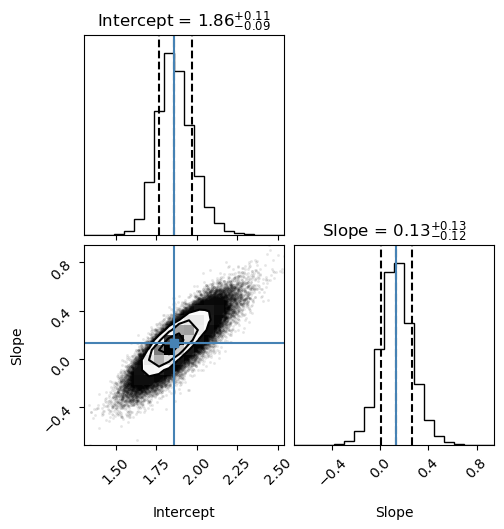

In [169]:
results = bayesian_regression_mcmc(
    x=df['x'].values, 
    y=df['y'].values, 
    y_err_lower=df['yerrl'].values/1.645, 
    y_err_upper=df['yerru'].values/1.645,
    x_err_lower=df['xerrl'].values/1.645, 
    x_err_upper=df['xerru'].values/1.645,
    x_min=-2, x_max=0.5,
    num_realizations=200
)
results

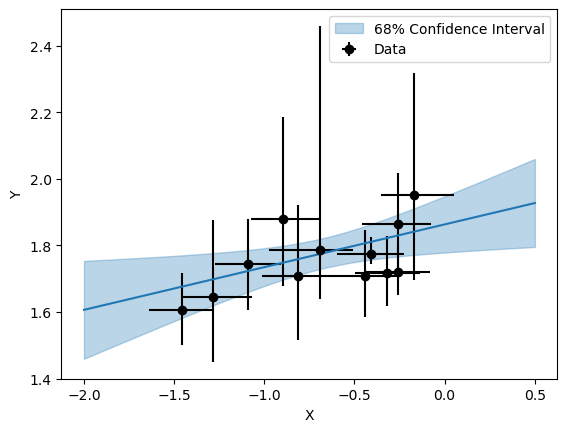

In [164]:
fig, ax = plt.subplots()
ax.errorbar(df['x'].values, df['y'].values, yerr=[df['yerrl'].values, df['yerru'].values], xerr=[df['xerrl'].values, df['xerru'].values], fmt='o', label='Data', color='black')
ax.plot(results['x_plot'], results['y_median'], color='tab:blue')#, label=f'Best Fit: y = {results['slope_median']:.2f} ± {results['slope_err_lower']:.2f}/{results['slope_err_upper']:.2f} x + {results['intercept_median']:.2f} ± {results['intercept_err_lower']:.2f}/{results['intercept_err_upper']:.2f}')
ax.fill_between(results['x_plot'], results['y_lower'], results['y_upper'], color='tab:blue', alpha=0.3, label='68% Confidence Interval')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.legend()